# Import Statements

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
import time

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.optim import lr_scheduler

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


# Helper Functions

In [2]:
def GetAround(arr, xs, ys, radius = 1):
    #Compute window size
    k = 2*radius + 1

    #Normalize shapes
    if arr.dim() == 2: #(nx,ny) -> (1,1,nx,ny)
        arr = arr.unsqueeze(0).unsqueeze(0)
    elif arr.dim() == 3: #(C,nx,ny) -> (1,C,nx,ny)
        arr = arr.unsqueeze(0)
    B, C, nx, ny = arr.shape

    #Validate inputs
    assert xs.shape == ys.shape and xs.dim() == 2, "xs,ys must be (B,M)"
    assert xs.size(0) == B, "batch dim of xs/ys must match arr"

    #Zero-pad so edges produce full kxk windows with zeros outside
    arrp = F.pad(arr, (radius, radius, radius, radius)) #(B,C,nx+2r,ny+2r)

    #Unfold into all kxk patches centered at each pixel
    #(B, C*k*k, nx*ny) -> transpose -> (B, nx*ny, C*k*k)
    patches_all = F.unfold(arrp, kernel_size=k, stride=1, padding=0) #(B, C*k*k, nx*ny)
    patches_all = patches_all.transpose(1, 2) #(B, nx*ny, C*k*k)

    #Flatten (x,y) to linear position indices
    lin = (xs*ny + ys) #(B,M)

    #Gather the (C*k*k) vectors for each requested (x,y)
    #Expand lin to shape (B,M, C*k*k) for take_along_dim
    gather_idx = lin.unsqueeze(-1).expand(-1, -1, C*k*k) #(B,M,C*k*k)
    sel = torch.take_along_dim(patches_all, gather_idx, dim=1) #(B,M,C*k*k)

    #Reshape to (B, M, C, k, k)
    patches = sel.view(B, -1, C, k, k)

    #Build in-bounds mask to emulate shrinking window
    #For each (x,y), valid local offsets are those that map inside [0,nx) x [0,ny)
    #Compute tensor of offsets
    off = torch.arange(-radius, radius+1, device=arr.device)
    dX = off.view(1, 1, k, 1) #(1,1,k,1)
    dY = off.view(1, 1, 1, k) #(1,1,1,k)

    X = xs.unsqueeze(-1).unsqueeze(-1) + dX #(B,M,k,1)
    Y = ys.unsqueeze(-1).unsqueeze(-1) + dY #(B,M,1,k)

    inX = (0 <= X) & (X < nx)
    inY = (0 <= Y) & (Y < ny)
    inbounds_mask = (inX & inY).squeeze(-1) #(B,M,k,k)

    return patches, inbounds_mask


def GetKernel(xs, ys, nx, ny, radius = 1):
    #Compute dimensions
    k = 2*radius + 1
    B = xs.shape[0]
    device = xs.device
    
    #Create base grid
    X = torch.arange(nx, device=device).view(1, nx, 1)
    Y = torch.arange(ny, device=device).view(1, 1, ny)
    
    #Create in-kernel mask for each (x,y)
    in_x = (X >= (xs - radius).view(B, 1, 1)) & (X < (xs + radius + 1).view(B, 1, 1))
    in_y = (Y >= (ys - radius).view(B, 1, 1)) & (Y < (ys + radius + 1).view(B, 1, 1))
    return in_x & in_y


def ConvMask(mines_bhw, radius=1, zero_center=True):
    # returns (B,H,W)
    x = mines_bhw.bool().float().unsqueeze(1) if mines_bhw.dim()==3 else mines_bhw.float()
    k = torch.tensor([[1,1,1],[1,0,1],[1,1,1]], dtype=torch.float32, device=x.device).view(1,1,3,3)
    c = F.conv2d(x, k, padding=1).squeeze(1).to(torch.int32)
    return c

In [3]:
_NEIGH_KERNEL = torch.tensor(
    [[1,1,1],
     [1,0,1],
     [1,1,1]], dtype=torch.float32
).view(1,1,3,3)

def _to_4d(mask: torch.Tensor) -> torch.Tensor:
    """
    Ensures shape = (B, 1, H, W).
    Accepts (H, W) or (B, H, W) or (B, 1, H, W).
    """
    if mask.dim() == 2:
        return mask.unsqueeze(0).unsqueeze(0)
    if mask.dim() == 3:
        return mask.unsqueeze(1)
    return mask

def neighbor_counts(mines: torch.Tensor) -> torch.Tensor:
    """
    mines: bool tensor (B,1,H,W) of mine locations.
    Returns int tensor (B,1,H,W) with 8-neighbor mine counts.
    """
    B, C, H, W = mines.shape
    kernel = _NEIGH_KERNEL.to(mines.device)
    # conv on float then cast back to int
    counts = F.conv2d(mines.float(), kernel, padding=1)
    return counts.to(torch.int32)

def binary_dilate(mask: torch.Tensor) -> torch.Tensor:
    """
    8-connected binary dilation using conv2d with a 3x3 ones kernel.
    mask: bool (B,1,H,W)
    Returns: bool (B,1,H,W)
    """
    kernel = torch.ones((1,1,3,3), dtype=torch.float32, device=mask.device)
    hits = F.conv2d(mask.float(), kernel, padding=1)
    return hits > 0

def flood_reveal(mines: torch.Tensor, clicks: torch.Tensor):
    """
    mines:  bool tensor (B,1,H,W) where True = mine
    clicks: bool tensor (B,1,H,W) initial clicked cells (can be multiple)

    Returns:
      revealed: bool (B,1,H,W) final revealed cells (zeros + border numbers)
      numbers:  int  (B,1,H,W) neighbor mine counts
    """
    mines = _to_4d(mines).bool()
    clicks = _to_4d(clicks).bool()
    device = mines.device

    # Precompute numbers and zero-cells
    numbers = neighbor_counts(mines)          # (B,1,H,W), int32
    zeros = (numbers == 0) & ~mines          # zero cells that are safe

    # Start frontier: clicked cells that are safe
    frontier = clicks & ~mines
    revealed_zero_region = frontier & zeros   # only zeros cause flood

    # We will expand zero-region only; nonzero neighbors get revealed at the end.
    # Track which batches are still growing to allow early exit per-batch (optional)
    B = mines.shape[0]
    active = (revealed_zero_region.any(dim=(-1,-2))).view(B,1,1,1)

    # Iterate until no change; typical boards terminate in few steps
    # Bound by (H*W) worst-case to avoid pathological loops
    H, W = mines.shape[-2:]
    for _ in range(H + W):
        if not active.any():
            break

        # Grow by dilating the current frontier
        dil = binary_dilate(frontier)

        # New cells to reveal as part of the zero-region:
        # - must be zero cells
        # - not already revealed
        # - not mines (already ensured by zeros)
        grow = dil & zeros & ~revealed_zero_region

        if not grow.any():
            break

        revealed_zero_region = revealed_zero_region | grow
        frontier = grow  # next wave

        # Update active batches
        batch_has_grow = grow.view(B, -1).any(dim=1).view(B,1,1,1)
        active = batch_has_grow

    # After zero-region is fully revealed, reveal the numbered border
    border_neighbors = binary_dilate(revealed_zero_region)
    border_numbers = border_neighbors & ~zeros & ~mines

    revealed = revealed_zero_region | border_numbers
    # Also reveal any initially clicked safe numbered cells (if user clicked a number)
    revealed = revealed | (clicks & ~mines)

    return revealed, numbers

# Minesweeper Environment Class

In [4]:
class MineEnv:
    def __init__(self, batch_size, grid_size, num_mines, errors=False):
        #Store parameters
        self.B = batch_size
        self.grid_size = grid_size
        self.num_mines = num_mines
        self.errors = errors
        
        #Calculate parameters
        self.nx, self.ny = grid_size
        self.n = self.nx*self.ny
        self.num_safe = self.n - self.num_mines
    
    
        
    def place_mines(self, x0s=None, y0s=None):
        #Select Random Starting Points, find neighborhood masks
        if x0s is None or y0s is None:
            x0s = torch.randint(0, self.nx, (self.B,), device=device)
            y0s = torch.randint(0, self.ny, (self.B,), device=device)
            nb_mask = GetKernel(x0s, y0s, self.nx, self.ny, radius=1)  #(B,nx,ny)
            forbidden = nb_mask.view(self.B, self.n)  
        
        #Place Initial Random Mines
        U = torch.rand(self.B, self.n, device=device)
        U = U.masked_fill(forbidden, float('inf'))  #Set forbidden cells to high value
        idx = torch.topk(U, self.num_mines, dim=1, largest=False).indices
        mines = torch.zeros(self.B, self.n, dtype=torch.bool, device=device)
        mines.scatter_(1, idx, True)
        self.mines = mines.view(self.B, self.nx, self.ny) #(B,H,W)
        
        #Initialize Revealed and Flagged Masks
        self.revealed = torch.zeros((self.B, self.nx, self.ny), dtype=torch.bool, device=device) #(B,H,W)
        self.revealed = self.revealed | nb_mask #(B,H,W)
        self.flagged = torch.zeros((self.B, self.nx, self.ny), dtype=torch.bool, device=device) #(B,H,W)

        #Flood reveal from initial clicks
        initial_clicks = torch.zeros((self.B, self.nx, self.ny), dtype=torch.bool, device=device)
        initial_clicks[torch.arange(self.B, device=device), x0s, y0s] = True
        flood_revealed, flood_counts = flood_reveal(self.mines, initial_clicks)
        self.revealed |= flood_revealed.squeeze(1) #(B,H,W)
        self.counts = flood_counts.squeeze(1)  #(B,H,W)
    
        #Intitialize games
        self.running = torch.ones(self.B, dtype=torch.bool, device=device)
    
    def reveal(self, xs, ys):
        #Reveal cells at (xs,ys), raise error if mine revealed
        if self.errors:
            assert not self.mines[torch.arange(self.B, device=device), xs, ys].any(), "Revealed a mine!"
        else:
            self.running &= ~self.mines[torch.arange(self.B, device=device), xs, ys]
        idx = (xs*self.ny + ys).view(self.B, 1)  #(B,1)
        self.revealed.view(self.B, -1).scatter_(1, idx, True)
        
        #Flood reveal if a zero-cell is revealed
        flood_revealed, flood_counts = flood_reveal(self.mines, self.revealed)
        self.revealed |= flood_revealed.squeeze(1)  #(B,H,W)
        self.counts = flood_counts.squeeze(1)  #(B,H,W)
        
    def flag(self, xs, ys):
        #Flag cells at (xs,ys), raise error if not a mine, raise error if already revealed
        if self.errors:
            assert self.mines[torch.arange(self.B, device=device), xs, ys].all(), "Flagged a non-mine!"
            assert not self.revealed[torch.arange(self.B, device=device), xs, ys].any(), "Flagged a revealed cell!"
        else:
            self.running &= ~self.revealed[torch.arange(self.B, device=device), xs, ys]
            self.running &= self.mines[torch.arange(self.B, device=device), xs, ys]
        idx = (xs*self.ny + ys).view(self.B, 1)  #(B,1)
        self.flagged.view(self.B, -1).scatter_(1, idx, True)
        
        #Update counts
        #self.counts = ConvMask(self.mines, radius=1, zero_center=True) #(B,H,W)
        
    def render(self, Bidx=0):
        #Index to batch and convert to numpy
        counts = self.counts[Bidx].cpu().numpy().astype(int)
        revealed = self.revealed[Bidx].cpu().numpy().astype(int)
        flagged = self.flagged[Bidx].cpu().numpy().astype(int)
        
        #Create Figure
        fig, ax = plt.subplots(figsize=(10,10))
        
        #Setting up custom colors
        count_colors = {
            1: "#1e90ff",
               2: "#2e8b57",
              3: "#ff4500",
            4: "#00008b",
            5: "#8b0000",
             6: "#2f4f4f",
              7: "#8b008b",
               8: "#808000"
        }
        unrevealed_color = "#bbbbbb"
        grid_color = "#4E4E4E"
        flag_color = "#ff0000"
        flag_symbol = '⚑'

        #Add Gray for unrevealed and counts for revealed, flags
        for x in range(self.nx):
            for y in range(self.ny):
                if revealed[x,y]==0:
                    rect = plt.Rectangle((x-0.5, y-0.5), 1, 1, color=unrevealed_color)
                    ax.add_patch(rect)
                else:
                    count = counts[x,y]
                    if count > 0:
                        ax.text(x, y, str(count), color=count_colors[count], 
                                fontsize=20, weight='bold', ha='center', va='center')
                if flagged[x,y]==1:
                    ax.text(x, y, s=flag_symbol, color=flag_color, 
                            fontsize=20, weight='bold', ha='center', va='center')
                    
        #Create Grid
        xarr = np.arange(0, self.nx, 1)
        yarr = np.arange(0, self.ny, 1)
        ax.set_xticks(xarr, labels=xarr.astype('str'), minor=False)
        ax.set_yticks(yarr, labels=yarr.astype('str'), minor=False)
        ax.set_xticks(xarr - 0.5, minor=True)
        ax.set_yticks(yarr - 0.5, minor=True)
        ax.grid(which='minor', color=grid_color, linestyle='-', linewidth=2)
        
        #Clip to limits
        ax.set_xlim([-0.5, self.nx-0.5])
        ax.set_ylim([-0.5, self.ny-0.5])
        
        #Label axes
        ax.set_xlabel('X', fontsize=16)
        ax.set_ylabel('Y', fontsize=16)

## Testing

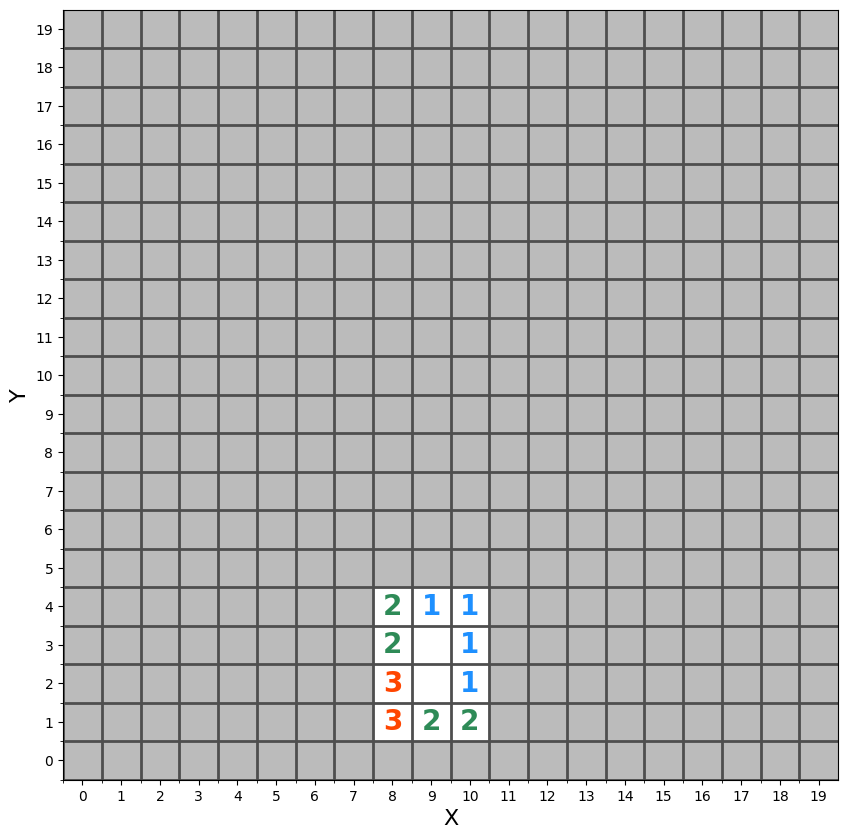

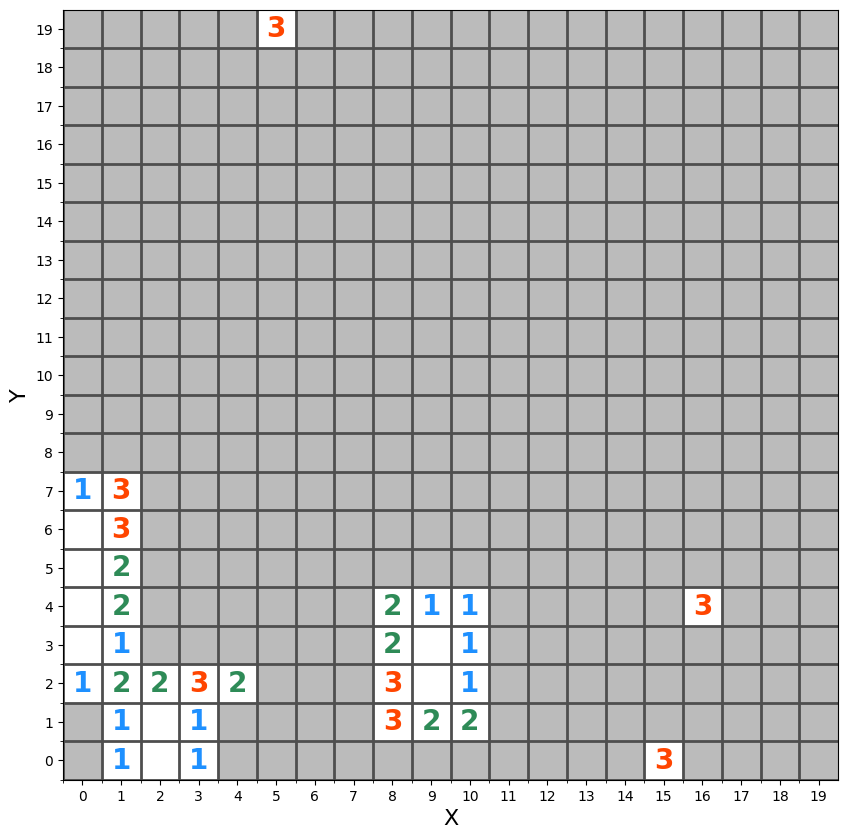

In [5]:
env = MineEnv(batch_size=100, grid_size=(20,20), num_mines=100)
env.place_mines()
env.render(Bidx=0)

for i in range(5):
    #Pick a random safe cell to reveal
    safe = ~env.mines & ~env.revealed
    num_safe = safe.sum(dim=(1,2))  #(B,)
    safe_flat = safe.view(env.B, -1)  #(B, n)
    x = torch.zeros(env.B, dtype=torch.long, device=device)
    y = torch.zeros(env.B, dtype=torch.long, device=device)
    for b in range(env.B):
        rand_idx = torch.randint(0, num_safe[b], (env.B,), device=device)  #(B,)
        safe_indices = torch.nonzero(safe_flat[b], as_tuple=False).view(-1)
        sel_idx = safe_indices[rand_idx[b]]
        x[b] = sel_idx // env.ny
        y[b] = sel_idx % env.ny
    env.reveal(x, y)
env.render(Bidx=0)

# MineNet

In [6]:
#RL CNN Agent
class MineNet(nn.Module):
	def __init__(self, grid_size):
		super(MineNet, self).__init__()
		nx, ny = grid_size
		self.conv1 = nn.Conv2d(3, 9, kernel_size=3, padding=1)
		self.conv2 = nn.Conv2d(9, 27, kernel_size=3, padding=1)
		self.conv3 = nn.Conv2d(27, 81, kernel_size=3, padding=1)
		self.fc1 = nn.Linear(81 * nx * ny, 256)
		self.fc2 = nn.Linear(256, nx * ny * 2)  # Output logits for reveal/flag for each cell
		
	def forward(self, revealed, flagged):
		x = torch.stack([revealed.float(), flagged.float()], dim=1)  # (B, 3, H, W)
		x = F.relu(self.conv1(x))
		x = F.relu(self.conv2(x))
		x = F.relu(self.conv3(x))
		x = x.view(x.size(0), -1)  # Flatten
		x = F.relu(self.fc1(x))
		x = self.fc2(x)  # (B, H*W, 2)
		return x


In [7]:
def GetInputs(MineEnv):
    counts = env.counts
    flagged = env.flagged
    revealed = env.revealed
    count_mask = revealed | flagged  #(B,H,W)
    counts = counts.masked_fill(~count_mask, -1)  #(B,H,W)
    input_counts = counts.float().to(device)
    input_flagged = flagged.float().to(device)
    input_revealed = revealed.float().to(device)
    tensor_input = torch.stack([input_counts, input_flagged, input_revealed], dim=1)  #(B,3,H,W)
    return tensor_input

In [ ]:
class MineEnv:
    def __init__(self, batch_size, grid_size, num_mines, device=None):
        # Store parameters
        self.B = batch_size
        self.grid_size = grid_size
        self.nx, self.ny = grid_size
        self.n = self.nx * self.ny
        self.num_mines = int(num_mines)
        self.num_safe = self.n - self.num_mines
        self.device = device or (torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu"))

        # State tensors (allocated on first reset)
        self.mines     = None  # (B,H,W) bool
        self.revealed  = None  # (B,H,W) bool
        self.flagged   = None  # (B,H,W) bool
        self.counts    = None  # (B,H,W) int32
        self.done      = None  # (B,)    bool   (lost or won)
        self.win       = None  # (B,)    bool
        self.loss      = None  # (B,)    bool

    # ---------- Core ops ----------
    def reset(self, x0s=None, y0s=None):
        """Start a new episode (new board) per batch item."""
        self.place_mines(x0s=x0s, y0s=y0s)
        self.done = torch.zeros(self.B, dtype=torch.bool, device=self.device)
        self.win  = torch.zeros_like(self.done)
        self.loss = torch.zeros_like(self.done)
        return self.get_observation()

    def place_mines(self, x0s=None, y0s=None):
        # Random starting clicks if not provided
        if x0s is None or y0s is None:
            x0s = torch.randint(0, self.nx, (self.B,), device=self.device)
            y0s = torch.randint(0, self.ny, (self.B,), device=self.device)

        # Neighborhood around initial clicks must be mine-free
        nb_mask = GetKernel(x0s, y0s, self.nx, self.ny, radius=1)  # (B,nx,ny)
        forbidden = nb_mask.view(self.B, self.n)                   # (B,n)

        # Sample mines with forbidden cells masked out
        U = torch.rand(self.B, self.n, device=self.device)
        U = U.masked_fill(forbidden, float('inf'))  # disallow initial neighborhood
        idx = torch.topk(U, self.num_mines, dim=1, largest=False).indices
        mines = torch.zeros(self.B, self.n, dtype=torch.bool, device=self.device)
        mines.scatter_(1, idx, True)
        self.mines = mines.view(self.B, self.nx, self.ny)          # (B,H,W)

        # Initialize masks
        self.revealed = torch.zeros((self.B, self.nx, self.ny), dtype=torch.bool, device=self.device)
        self.flagged  = torch.zeros_like(self.revealed)

        # Flood-reveal starting from the clicks
        initial_clicks = torch.zeros_like(self.revealed, dtype=torch.bool)
        initial_clicks[torch.arange(self.B, device=self.device), x0s, y0s] = True

        flood_revealed, flood_counts = flood_reveal(self.mines, initial_clicks)

        # Reveal: union of flood result and the protected neighborhood (optional but friendly)
        flood_revealed, flood_counts = flood_reveal(self.mines, initial_clicks)
        if flood_revealed.dim() == 4 and flood_revealed.size(1) == 1:
            flood_revealed = flood_revealed.squeeze(1)
        if flood_counts.dim() == 4 and flood_counts.size(1) == 1:
            flood_counts = flood_counts.squeeze(1)

        self.revealed = (flood_revealed | nb_mask).to(torch.bool)  # (B,H,W)
        self.counts   = flood_counts.to(torch.int32)  

    def reveal(self, xs, ys, batch_mask=None):
    xs = xs.to(self.device)
    ys = ys.to(self.device)

    alive = ~self.done
    if batch_mask is not None:
        alive = alive & batch_mask  # <<< only act on selected batches

    if not alive.any():
        return

    idx_b = torch.arange(self.B, device=self.device)
    click_mask = torch.zeros_like(self.revealed, dtype=torch.bool)
    sel = idx_b[alive]
    click_mask[sel, xs[alive], ys[alive]] = True

    hit_mine = (self.mines & click_mask).view(self.B, -1).any(dim=1)
    newly_lost = hit_mine & alive
    if newly_lost.any():
        self.done |= newly_lost
        self.loss |= newly_lost

    safe_clicks = click_mask & ~self.mines
    if safe_clicks.any():
        flood_revealed, _ = flood_reveal(self.mines, safe_clicks)
        # squeeze channel if needed
        if flood_revealed.dim() == 4 and flood_revealed.size(1) == 1:
            flood_revealed = flood_revealed.squeeze(1)
        self.revealed |= flood_revealed

    safe_cells_revealed = (~self.mines & self.revealed).view(self.B, -1).sum(dim=1)
    won = (safe_cells_revealed == self.num_safe) & ~self.done
    if won.any():
        self.done |= won
        self.win  |= won

def flag(self, xs, ys, batch_mask=None):
    xs = xs.to(self.device)
    ys = ys.to(self.device)

    alive = ~self.done
    if batch_mask is not None:
        alive = alive & batch_mask  # <<< only act on selected batches

    idx_b = torch.arange(self.B, device=self.device)
    sel = idx_b[alive]
    if sel.numel() == 0:
        return

    not_revealed = ~self.revealed[sel, xs[alive], ys[alive]]
    if not_revealed.any():
        s = sel[not_revealed]; x = xs[alive][not_revealed]; y = ys[alive][not_revealed]
        self.flagged[s, x, y] = True

    all_safe_revealed = (~self.mines & self.revealed).view(self.B, -1).sum(dim=1) == self.num_safe
    flags_match = (self.flagged == self.mines).view(self.B, -1).all(dim=1)
    won = all_safe_revealed & flags_match & ~self.done
    if won.any():
        self.done |= won
        self.win  |= won

    # ---------- RL-style interface ----------
    def step(self, xs, ys, action='reveal'):
        """
        xs, ys: Long tensors of shape (B,) with grid coordinates per batch.
        action: 'reveal' or 'flag'.

        Returns:
          obs:   dict of tensors for agent consumption
          reward: tensor (B,)
          done:   tensor (B,) bool
          info:   dict
        """
        if isinstance(xs, int):
            xs = torch.full((self.B,), xs, dtype=torch.long, device=self.device)
        if isinstance(ys, int):
            ys = torch.full((self.B,), ys, dtype=torch.long, device=self.device)

        before_done = self.done.clone()

        if action == 'reveal':
            self.reveal(xs, ys)
        elif action == 'flag':
            self.flag(xs, ys)
        else:
            raise ValueError("action must be 'reveal' or 'flag'")

        # Simple shaping:
        # +1 for newly revealed safe cell, 0 else; -10 for losing, +10 for winning
        newly_done = self.done & ~before_done
        newly_won  = newly_done & self.win
        newly_lost = newly_done & self.loss

        # Count how many cells were newly revealed by this action
        # (Approx: recompute observable safe cells and diff; cheap enough.)
        safe_now = (~self.mines & self.revealed).view(self.B, -1).sum(dim=1).float()
        if not hasattr(self, "_safe_prev"):
            self._safe_prev = torch.zeros_like(safe_now)
        newly_revealed = (safe_now - self._safe_prev).clamp(min=0.0)
        self._safe_prev = safe_now

        reward = newly_revealed
        reward[newly_won]  += 10.0
        reward[newly_lost] -= 10.0

        obs = self.get_observation()
        info = {"won": self.win.clone(), "lost": self.loss.clone()}
        return obs, reward, self.done.clone(), info

    def get_observation(self):
        """
        Returns a dict of useful tensors for learning or UI:
          - visible_counts: int32 (B,H,W) counts where revealed else 0
          - revealed:       bool  (B,H,W)
          - flagged:        bool  (B,H,W)
        """
        visible_counts = torch.where(self.revealed, self.counts, torch.zeros_like(self.counts))
        return {
            "visible_counts": visible_counts,
            "revealed": self.revealed.clone(),
            "flagged": self.flagged.clone(),
        }

    # ---------- Rendering ----------
    def render(self, Bidx=0, show_mines=False):
        """Matplotlib render. Set show_mines=True to display mines explicitly."""
        import matplotlib.pyplot as plt
        import numpy as np

        counts   = self.counts[Bidx].detach().cpu().numpy().astype(int)
        revealed = self.revealed[Bidx].detach().cpu().numpy().astype(bool)
        flagged  = self.flagged[Bidx].detach().cpu().numpy().astype(bool)
        mines    = self.mines[Bidx].detach().cpu().numpy().astype(bool)

        fig, ax = plt.subplots(figsize=(8, 8))

        # Colors
        count_colors = {
            1: "#1e90ff", 2: "#2e8b57", 3: "#ff4500", 4: "#00008b",
            5: "#8b0000", 6: "#2f4f4f", 7: "#8b008b", 8: "#808000"
        }
        unrevealed_color = "#bbbbbb"
        grid_color = "#4E4E4E"
        flag_color = "#ff0000"
        mine_color = "#000000"
        flag_symbol = '⚑'

        # Draw cells
        # Note: using x as column (j), y as row (i) to keep plot axes conventional.
        for i in range(self.nx):
            for j in range(self.ny):
                x, y = j, i  # (col, row)
                if not revealed[i, j]:
                    ax.add_patch(plt.Rectangle((x-0.5, y-0.5), 1, 1, color=unrevealed_color))
                else:
                    c = counts[i, j]
                    if c > 0:
                        ax.text(x, y, str(c), color=count_colors.get(c, "k"),
                                fontsize=16, weight='bold', ha='center', va='center')
                if flagged[i, j]:
                    ax.text(x, y, s=flag_symbol, color=flag_color,
                            fontsize=18, weight='bold', ha='center', va='center')

        # Optionally draw mines (e.g., after loss)
        if show_mines:
            mine_ys, mine_xs = np.where(mines)
            ax.scatter(mine_xs, mine_ys, marker='*', s=140, c=mine_color)

        # Grid
        xarr = np.arange(0, self.ny, 1)
        yarr = np.arange(0, self.nx, 1)
        ax.set_xticks(xarr, labels=xarr.astype('str'))
        ax.set_yticks(yarr, labels=yarr.astype('str'))
        ax.set_xticks(xarr - 0.5, minor=True)
        ax.set_yticks(yarr - 0.5, minor=True)
        ax.grid(which='minor', color=grid_color, linestyle='-', linewidth=1)

        # Limits and labels
        ax.set_xlim([-0.5, self.ny - 0.5])
        ax.set_ylim([-0.5, self.nx - 0.5])
        ax.invert_yaxis()  # top-left origin like a board
        ax.set_xlabel('Y (col)')
        ax.set_ylabel('X (row)')
        ax.set_title(f'Batch {Bidx} | mines={self.num_mines} | '
                     f'win={bool(self.win[Bidx])} loss={bool(self.loss[Bidx])}')
        plt.show()

#RL CNN Agent
class MineNet(nn.Module):
    """
    Inputs: (B, 3, H, W) = [counts_masked, flagged, revealed]
      - counts_masked: int in {-1,0..8}  (we'll pass .float() directly)
    Output: (B, H*W, 2) logits for [reveal, flag] per cell
    """
    def __init__(self, grid_size):
        super().__init__()
        nx, ny = grid_size
        self.nx, self.ny = nx, ny
        self.conv1 = nn.Conv2d(3,   16, 3, padding=1)
        self.conv2 = nn.Conv2d(16,  64, 3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        self.head  = nn.Conv2d(128, 2,  1)   # per-cell 2-logits
        # light weight, avoids huge fully-connected

    def forward(self, x3):
        # x3: (B,3,H,W)
        x = F.relu(self.conv1(x3))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = self.head(x)                    # (B,2,H,W)
        x = x.permute(0, 2, 3, 1).contiguous()  # (B,H,W,2)
        x = x.view(x.size(0), -1, 2)        # (B,H*W,2)
        return x

def get_inputs(env):
    """
    Build (B,3,H,W): counts_masked, flagged, revealed
    Accepts env tensors that may be (B,1,H,W) or (B,H,W).
    """
    counts   = env.counts
    revealed = env.revealed
    flagged  = env.flagged

    # Squeeze away a singleton channel if present
    if counts.dim()   == 4 and counts.size(1)   == 1: counts   = counts.squeeze(1)
    if revealed.dim() == 4 and revealed.size(1) == 1: revealed = revealed.squeeze(1)
    if flagged.dim()  == 4 and flagged.size(1)  == 1: flagged  = flagged.squeeze(1)

    # Sanity checks
    B, H, W = counts.shape
    assert revealed.shape == (B, H, W) and flagged.shape == (B, H, W), \
        f"Shape mismatch: counts {counts.shape}, revealed {revealed.shape}, flagged {flagged.shape}"

    # Mask unknown cells to -1
    known = revealed | flagged                                   # (B,H,W)
    cmask = torch.where(known, counts, torch.full_like(counts, -1))
    x_counts   = cmask.float()
    x_flagged  = flagged.float()
    x_revealed = revealed.float()

    x3 = torch.stack([x_counts, x_flagged, x_revealed], dim=1)   # (B,3,H,W)
    return x3.to(counts.device)



@torch.no_grad()
def make_action_masks(env):
    """
    Returns two (B,H*W) bool masks:
      - legal_reveal: cell can be revealed (not revealed, not flagged)
      - legal_flag:   cell can be flagged (not revealed)   [classic rules]
    """
    B, H, W = env.mines.shape
    revealed = env.revealed
    flagged  = env.flagged

    legal_reveal = (~revealed & ~flagged).view(B, H*W)
    legal_flag   = (~revealed).view(B, H*W)
    return legal_reveal, legal_flag

BIG_NEG = -1e9

def mask_illegal_logits(cell_logits, legal_reveal, legal_flag):
    """
    cell_logits: (B, H*W, 2) for [reveal, flag]
    legal_*:     (B, H*W) bool
    Returns same shape where illegal logits are set to BIG_NEG (not -inf).
    """
    out = cell_logits.clone()
    out[..., 0] = torch.where(legal_reveal, out[..., 0], torch.full_like(out[..., 0], BIG_NEG))
    out[..., 1] = torch.where(legal_flag,   out[..., 1], torch.full_like(out[..., 1], BIG_NEG))
    return out


def TrainMineNet(
    num_epochs,
    batch_size,
    grid_size,
    num_mines,
    learning_rate=1e-3,
    gamma=0.99,
    win_reward=1000.0,
    lose_reward=-500.0,
    step_reward=2.0,
    device=None
):
    device = device or (torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu"))
    H, W = grid_size

    env = MineEnv(batch_size=batch_size, grid_size=grid_size, num_mines=num_mines, device=device)
    model = MineNet(grid_size).to(device)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    for epoch in range(num_epochs):
        # (Re)start all boards
        _ = env.reset()

        # storage for policy gradient
        logps = []
        rews  = []

        steps = 0
        while (~env.done).any():
            # ---- Build input & forward ----
            x3 = get_inputs(env).to(device)                  # (B,3,H,W)
            logits = model(x3)                               # (B,N,2), N = H*W

            # Mask illegal actions to BIG_NEG
            legal_reveal, legal_flag = make_action_masks(env)         # (B,N)
            logits_m = mask_illegal_logits(logits, legal_reveal, legal_flag)

            # For each head, if **all** cells are illegal, mark that head unusable
            # (create a mask of batches with at least one legal cell per head)
            has_legal_reveal = legal_reveal.any(dim=1)   # (B,)
            has_legal_flag   = legal_flag.any(dim=1)     # (B,)

            # Softmax (stable) over action dim (size=2) — safe because we avoided -inf
            probs = F.softmax(logits_m, dim=-1)          # (B,N,2)
            probs = torch.nan_to_num(probs, nan=0.0)     # extra guard

            pr = probs[..., 0]    # (B,N)
            pf = probs[..., 1]    # (B,N)

            # Argmax per head, but if no legal for a head, give value = -1 so the other head wins
            best_r_val, best_r_idx = pr.max(dim=-1)      # (B,), (B,)
            best_f_val, best_f_idx = pf.max(dim=-1)      # (B,), (B,)

            # If a head has no legal actions, force its value very low
            best_r_val = torch.where(has_legal_reveal, best_r_val, torch.full_like(best_r_val, -1.0))
            best_f_val = torch.where(has_legal_flag,   best_f_val,   torch.full_like(best_f_val, -1.0))

            do_reveal = best_r_val >= best_f_val                             # (B,)
            chosen_idx = torch.where(do_reveal, best_r_idx, best_f_idx)      # (B,)
            chosen_act = torch.where(do_reveal,
                                    torch.zeros_like(best_r_idx),           # 0 = reveal
                                    torch.ones_like(best_f_idx))            # 1 = flag

            # Convert flat index -> (x,y)
            H, W = grid_size
            xs = (chosen_idx // W).long()
            ys = (chosen_idx %  W).long()

            # ---- Reward shaping: count newly revealed safe cells ----
            before_done = env.done.clone()  # (B,)

            safe_before = (~env.mines & env.revealed).view(batch_size, -1).sum(dim=1).float()

            # Batch step (env ignores done boards internally)
            alive = ~env.done
            reveal_mask = (do_reveal & alive)
            flag_mask   = ((~do_reveal) & alive)

            if reveal_mask.any():
                env.reveal(xs, ys, batch_mask=reveal_mask)
            if flag_mask.any():
                env.flag(xs, ys, batch_mask=flag_mask)

            safe_after = (~env.mines & env.revealed).view(batch_size, -1).sum(dim=1).float()
            dense = (safe_after - safe_before).clamp(min=0.0) * step_reward

            newly_done  = env.done & ~before_done
            bonus       = torch.zeros(batch_size, device=device)
            bonus[newly_done & env.win]  = win_reward
            bonus[newly_done & env.loss] = lose_reward

            reward = dense + bonus    # (B,)
            rews.append(reward.detach())

            # ---- Log-prob of chosen (cell, action) ----
            logp_all = F.log_softmax(logits_m, dim=-1)                      # (B,N,2)
            logp_all = torch.nan_to_num(logp_all, nan=BIG_NEG)              # guard
            b_idx = torch.arange(batch_size, device=device)
            chosen_logp = logp_all[b_idx, chosen_idx, chosen_act]           # (B,)
            # in case a batch had truly no legal actions across both heads (should imply done), clip:
            chosen_logp = torch.clamp(chosen_logp, min=BIG_NEG, max=0.0)
            logps.append(chosen_logp)

            steps += 1
            if steps > H * W * 3:  # hard safety
                break

        # ======= Policy gradient update (REINFORCE with simple returns) =======
        # Stack into (T,B)
        L = len(logps)
        logps_t = torch.stack(logps, dim=0)   # (T,B)
        rews_t  = torch.stack(rews,  dim=0)   # (T,B)

        # discounted returns
        returns = torch.zeros_like(rews_t)
        running = torch.zeros(batch_size, device=device)
        for t in reversed(range(len(rews_t))):
            running = rews_t[t] + gamma * running
            returns[t] = running

        # normalize
        mean, std = returns.mean(), returns.std()
        std = torch.clamp(std, min=1e-6)
        adv = (returns - mean) / std

        # policy loss
        policy_loss = -(logps_t * adv.detach()).mean()

        # light entropy (encourage exploration & avoid collapse)
        with torch.no_grad():
            # recompute a small sample for entropy; or cache last probs/logits_m as needed
            pass
        # Cheaper: add tiny L2 on logits to discourage extreme magnitudes (optional)
        # l2 = 1e-6 * sum(p.pow(2).sum() for p in model.parameters())
        entropy_bonus = 0.0  # start at 0; you can add real entropy if you cache the probs
        loss = policy_loss  # + l2 - beta * entropy  (if you add it)

        optimizer.zero_grad(set_to_none=True)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        # guard against NaN grads
        for p in model.parameters():
            if p.grad is not None:
                p.grad = torch.nan_to_num(p.grad, nan=0.0, posinf=1.0, neginf=-1.0)
        optimizer.step()

        with torch.no_grad():
            ep_reward = rews_t.sum(dim=0).mean().item()
        print(f"Epoch {epoch+1}/{num_epochs} | steps={steps} | loss={loss.item():.4f} | avg_ep_reward={ep_reward:.1f}")

In [9]:
TrainMineNet(num_epochs=50, batch_size=256, grid_size=(20,20), num_mines=15)

OutOfMemoryError: CUDA out of memory. Tried to allocate 50.00 MiB. GPU 0 has a total capacity of 23.99 GiB of which 0 bytes is free. Of the allocated memory 85.51 GiB is allocated by PyTorch, and 63.70 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)